Library import and data plot

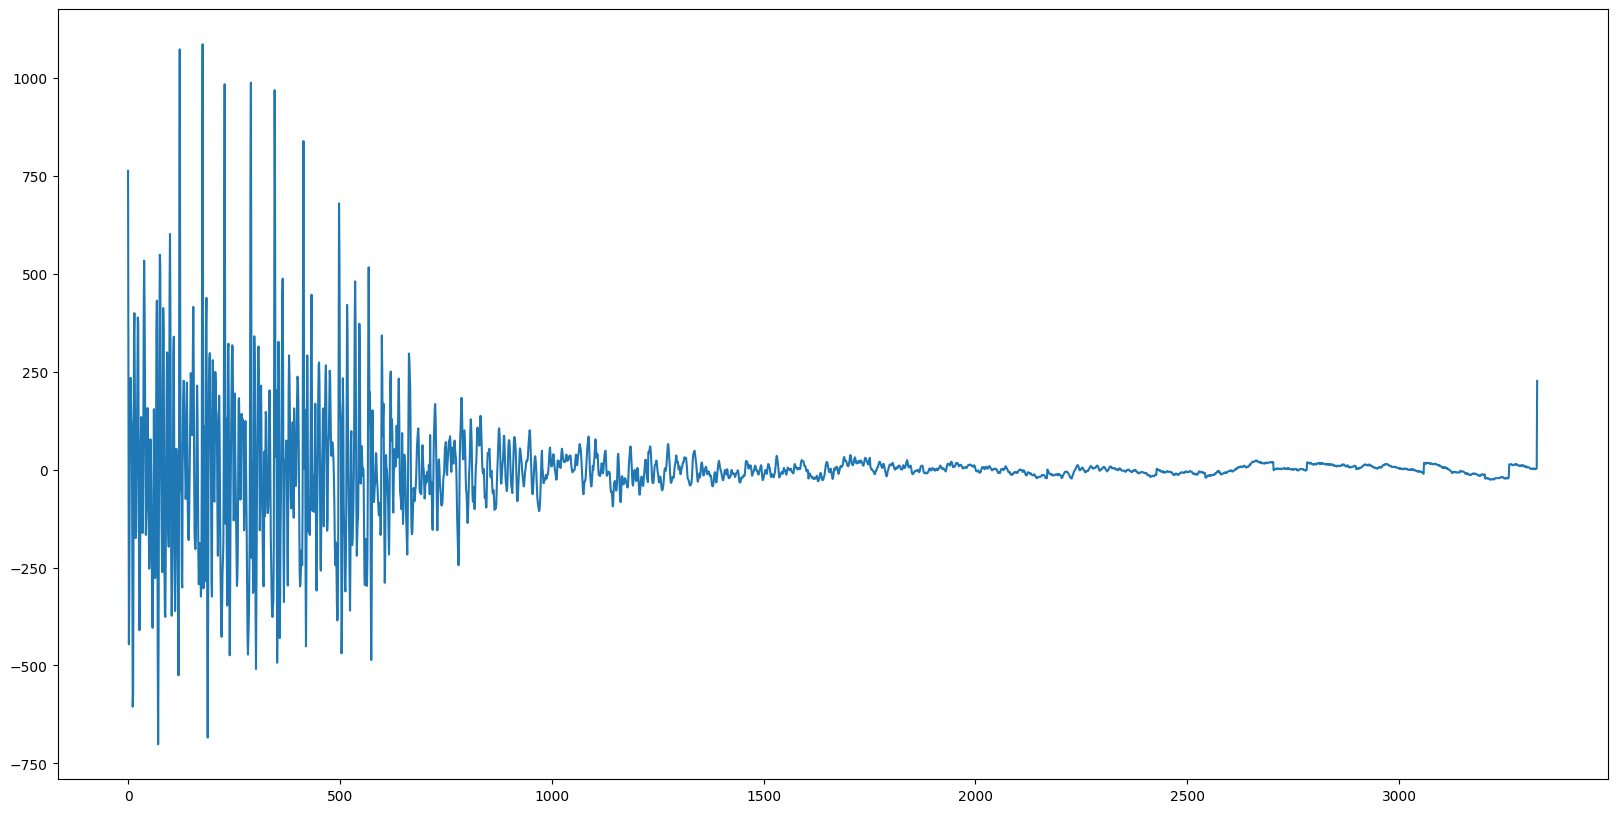

332800
3327
1419.0


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

fs = 16000

folder = 'data_set/'
file_name = 'now.txt'

samples_per_record = int (3327)
start=2
end = start + samples_per_record

data = np.loadtxt(folder+file_name)

# idx = range(len(data))
idx = range(len(data[start:end]))
idx
plt.plot(idx,data[start:end])
plt.show()
print(len(data))
print(len(idx))
print(max(data))


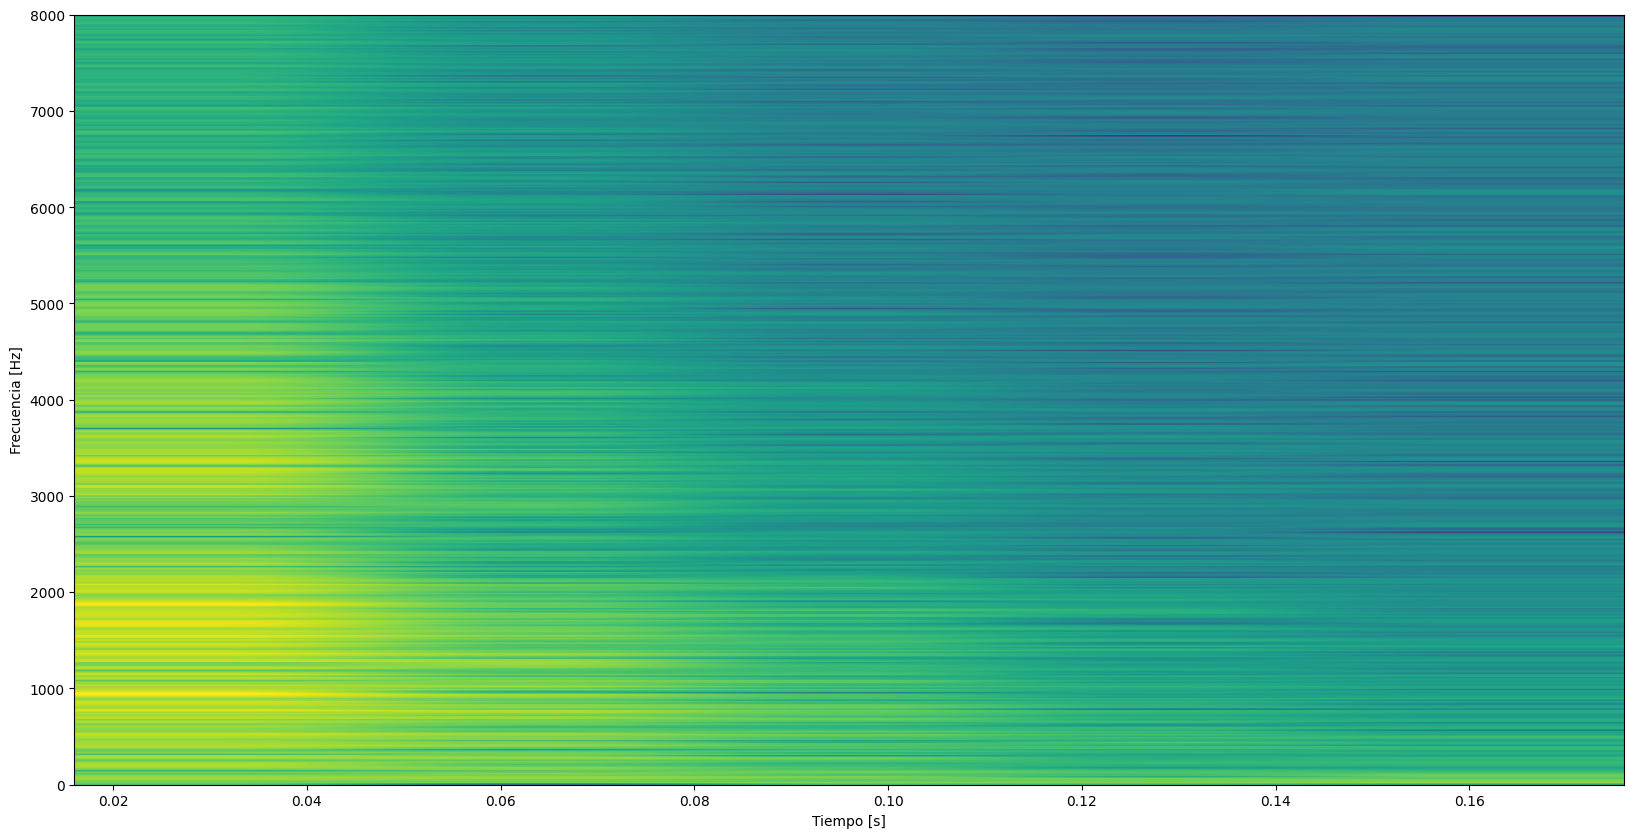

[[1.57620574e-01 2.12297625e-05 9.28283930e-02 4.13984015e-02
  9.69088446e-03]
 [8.02365210e-01 9.09350424e-01 1.32290715e+00 1.27100713e+00
  1.87712473e+00]
 [7.68509628e-01 7.77102989e-01 4.46045615e-01 7.65367243e-01
  1.36365164e+00]
 ...
 [3.73553824e-02 8.92899691e-04 1.36132573e-04 2.42788575e-05
  7.85359586e-05]
 [2.24001133e-02 2.13672162e-03 3.63438723e-04 6.36720724e-05
  3.95520987e-05]
 [7.13640870e-03 1.44562220e-03 8.12957074e-07 2.10800316e-08
  2.12443919e-09]]
<class 'numpy.ndarray'>
(513, 5)


In [18]:
# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2

# Constants from the data set adquisition
time_per_sample = 2
samples_per_record = int (3327)

start=2
end = start + samples_per_record

# Calcular el espectrograma
# spec, freqs, times, _ = plt.specgram(data, NFFT=nfft, Fs=fs, window=win, noverlap=hop)
spec, freqs, times, _ = plt.specgram(data[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop)



# Representar gráficamente el espectrograma
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.show()
print(spec)

print(type(spec))
print(spec.shape)

Data parse

TensorFlow version = 2.12.0

Processing index 0 for command 'now'.
	There are 100 recordings of the now command.
Processing index 1 for command 'coral_take'.
	There are 106 recordings of the coral_take command.
Processing index 2 for command 'ruido'.
	There are 105 recordings of the ruido command.
Data set parsing and preparation complete.


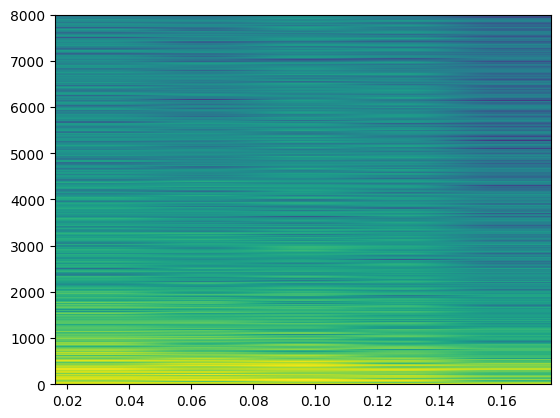

In [3]:
print(f"TensorFlow version = {tf.__version__}\n")

# List of commands that the nn will recognize
commands = ['now', 'coral_take','ruido']

# Constants from the data set adquisition
# time_per_sample = 2
# samples_per_record = int (3327/3)

num_commands = len(commands)

# create a one-hot encoded matrix that is used in the output
encoded_commands = np.eye(num_commands)

inputs = []
outputs = []

# Definir los parámetros para el espectrograma
win = np.hamming(1024)
nfft = 1024
hop = nfft // 2

# read each csv file and push an input and output
for command_idx in range(num_commands):
  command = commands[command_idx]
  print(f"Processing index {command_idx} for command '{command}'.")
  
  output = encoded_commands[command_idx]
  
  df = np.loadtxt("data_set/" + command + ".txt")
  
  # calculate the number of command recordings in the file
  num_recordings = int(df.shape[0] / samples_per_record)
  
  print(f"\tThere are {num_recordings} recordings of the {command} command.")
  
  for i in range(num_recordings):
    tensor = []
    # print(i*samples_per_record)
    # print()
    start = i*samples_per_record
    end = start+samples_per_record
    spec, freqs, times, _ = plt.specgram(df[start:end], NFFT=nfft, Fs=fs, window=win, noverlap=hop, mode='magnitude')
    tensor = spec

    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")



In [4]:
print(inputs[4].shape)
print(inputs[2].shape)

(513, 5)
(513, 5)


Randomize samples

In [5]:
# Sort inputs randomly
num_inputs = len(inputs)
random_idx = np.arange(num_inputs)
np.random.shuffle(random_idx)

inputs = inputs[random_idx]
outputs = outputs[random_idx]

# Split the inputs into: training (60%), testing(20%) and validation(20%)
train_idx = int(0.6 * num_inputs)
test_idx = int(0.2 * num_inputs + train_idx)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [train_idx, test_idx])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [train_idx, test_idx])

# Ajustar la forma de los datos de entrada
inputs_train = np.expand_dims(inputs_train, axis=1)
inputs_validate = np.expand_dims(inputs_validate, axis=1)
inputs_test = np.expand_dims(inputs_test, axis=1)

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


Model training and bulding

In [6]:
# build the model and train it

# Define the input shape
input_shape = inputs_train[1].shape
print(inputs_train[1].shape)

# Define the number of filters and filter sizes for the first layer
filters_layer_1 = 5
filter_size_layer_1 = (10,10)
model = 0
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(filters=filters_layer_1, padding='same', kernel_size=filter_size_layer_1,activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(num_commands, activation='softmax'))
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=70, batch_size=1, validation_data=(inputs_validate, outputs_validate))

(1, 513, 5)
Epoch 1/70
186/186 [==============================] - 1s 3ms/step - loss: 0.0575 - mae: 0.1179 - val_loss: 0.0026 - val_mae: 0.0101
Epoch 2/70
186/186 [==============================] - 0s 2ms/step - loss: 0.0092 - mae: 0.0170 - val_loss: 0.0131 - val_mae: 0.0260
Epoch 3/70
186/186 [==============================] - 0s 2ms/step - loss: 2.2793e-04 - mae: 0.0027 - val_loss: 2.9093e-06 - val_mae: 3.3564e-04
Epoch 4/70
186/186 [==============================] - 0s 2ms/step - loss: 7.1443e-07 - mae: 1.9452e-04 - val_loss: 4.8324e-08 - val_mae: 6.4073e-05
Epoch 5/70
186/186 [==============================] - 0s 2ms/step - loss: 6.2803e-08 - mae: 5.5015e-05 - val_loss: 4.5872e-08 - val_mae: 6.2690e-05
Epoch 6/70
186/186 [==============================] - 0s 2ms/step - loss: 4.7305e-08 - mae: 5.1581e-05 - val_loss: 3.5034e-08 - val_mae: 5.4623e-05
Epoch 7/70
186/186 [==============================] - 0s 2ms/step - loss: 3.6538e-08 - mae: 4.5686e-05 - val_loss: 2.9820e-08 - val_mae:

Loss graph

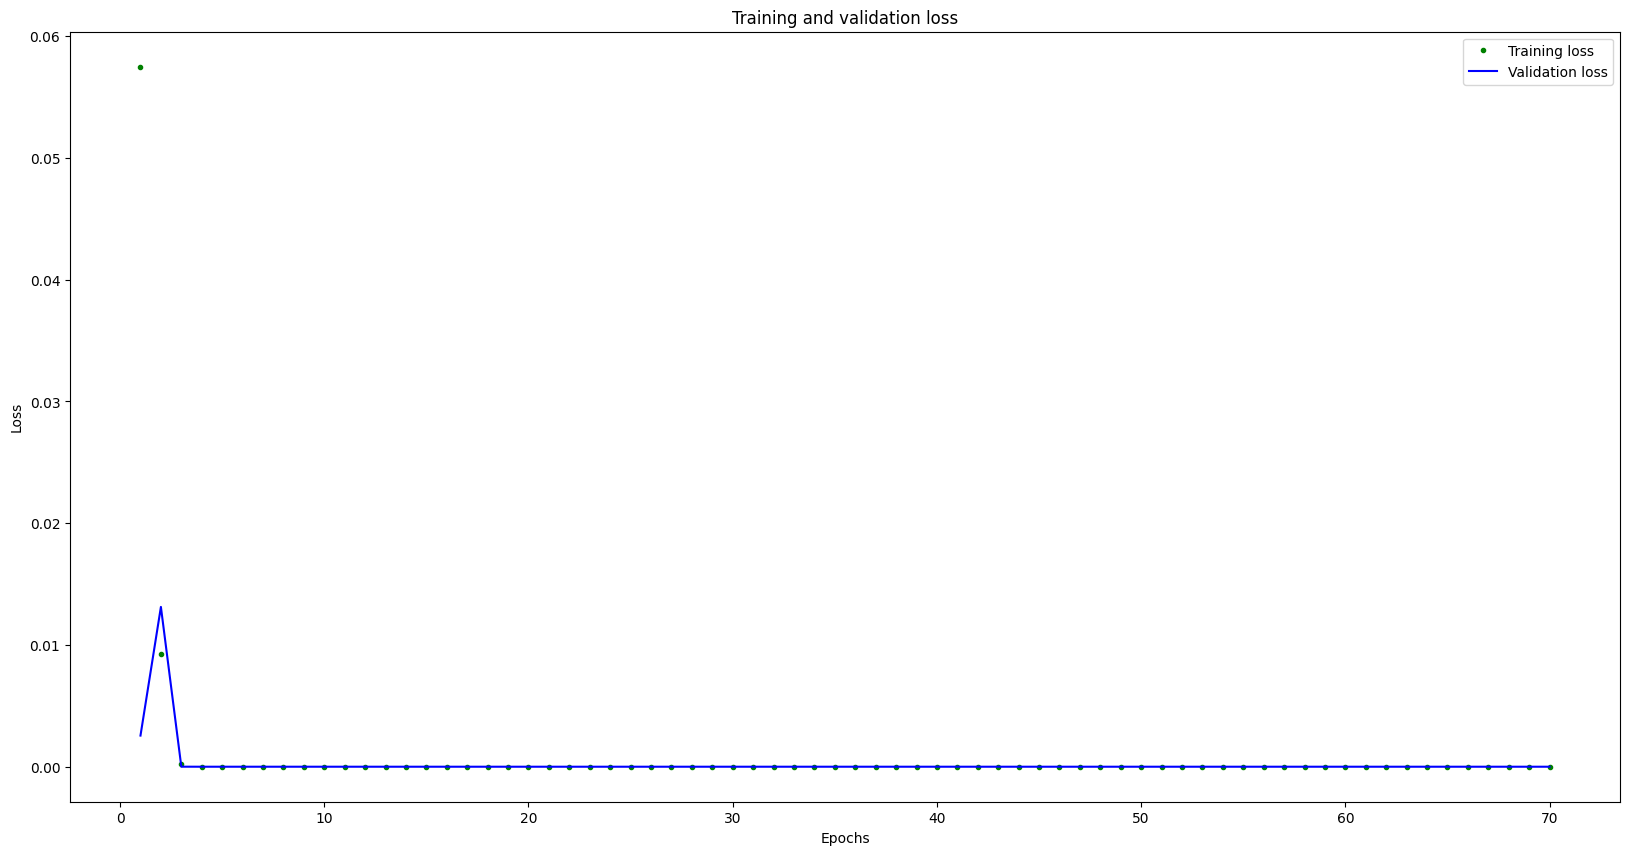

[20.0, 10.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

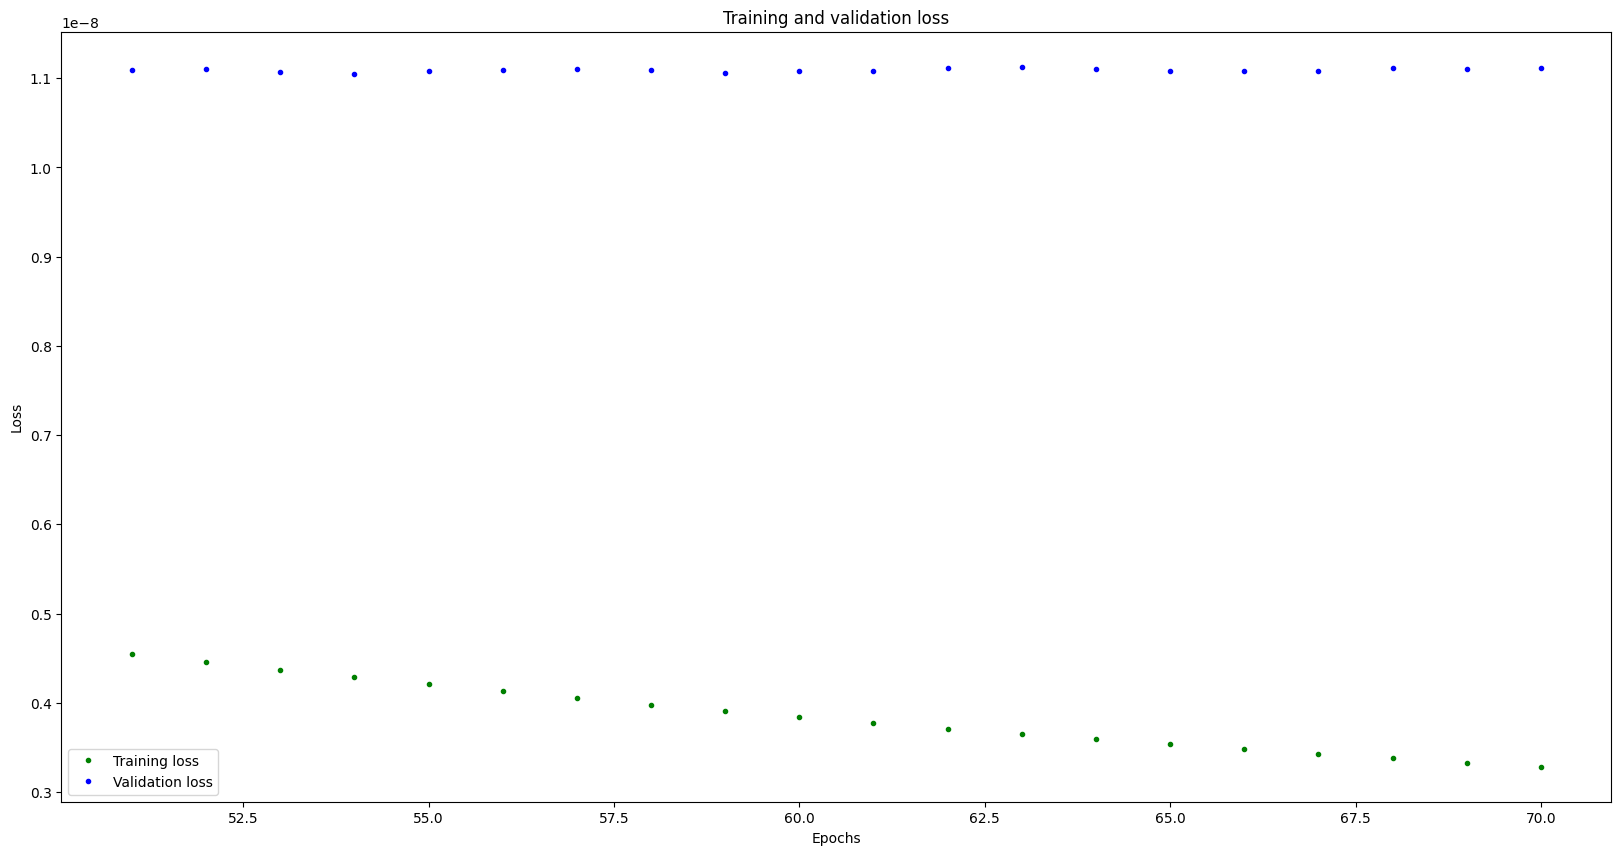

In [8]:
# graph the loss again skipping a bit of the start
SKIP = 50
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Mean absolute error graph

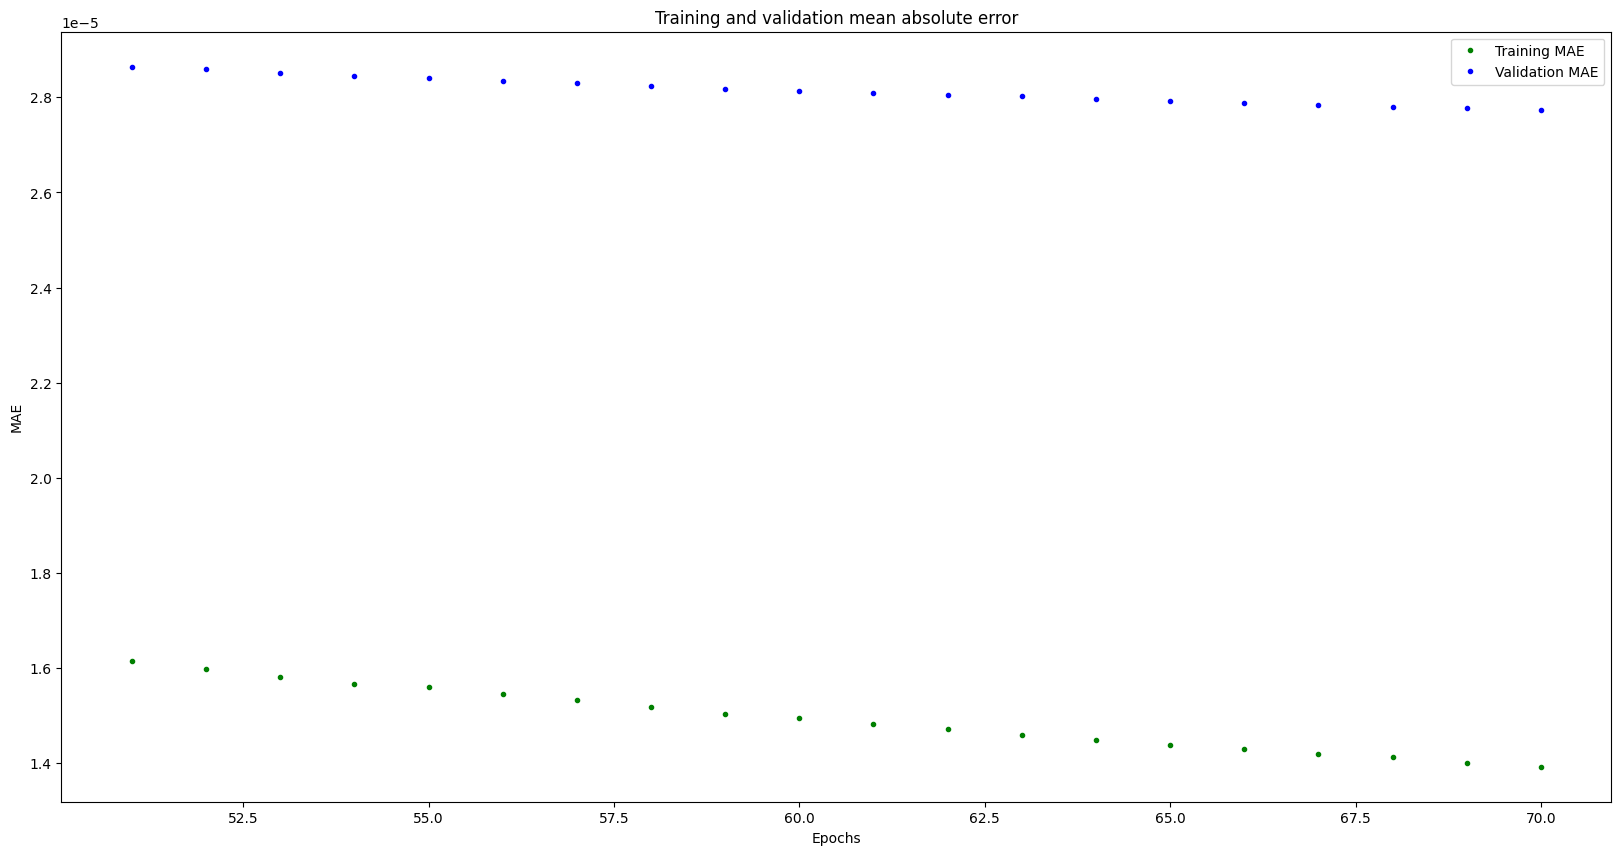

In [9]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [10]:
print(outputs_test.shape)
len((outputs_test[1]))

(62, 3)


3

Test model predictions

2/2 [==============================] - 0s 3ms/step
class: 3
[[23.  0.  0.]
 [ 0. 17.  1.]
 [ 0.  0. 21.]]


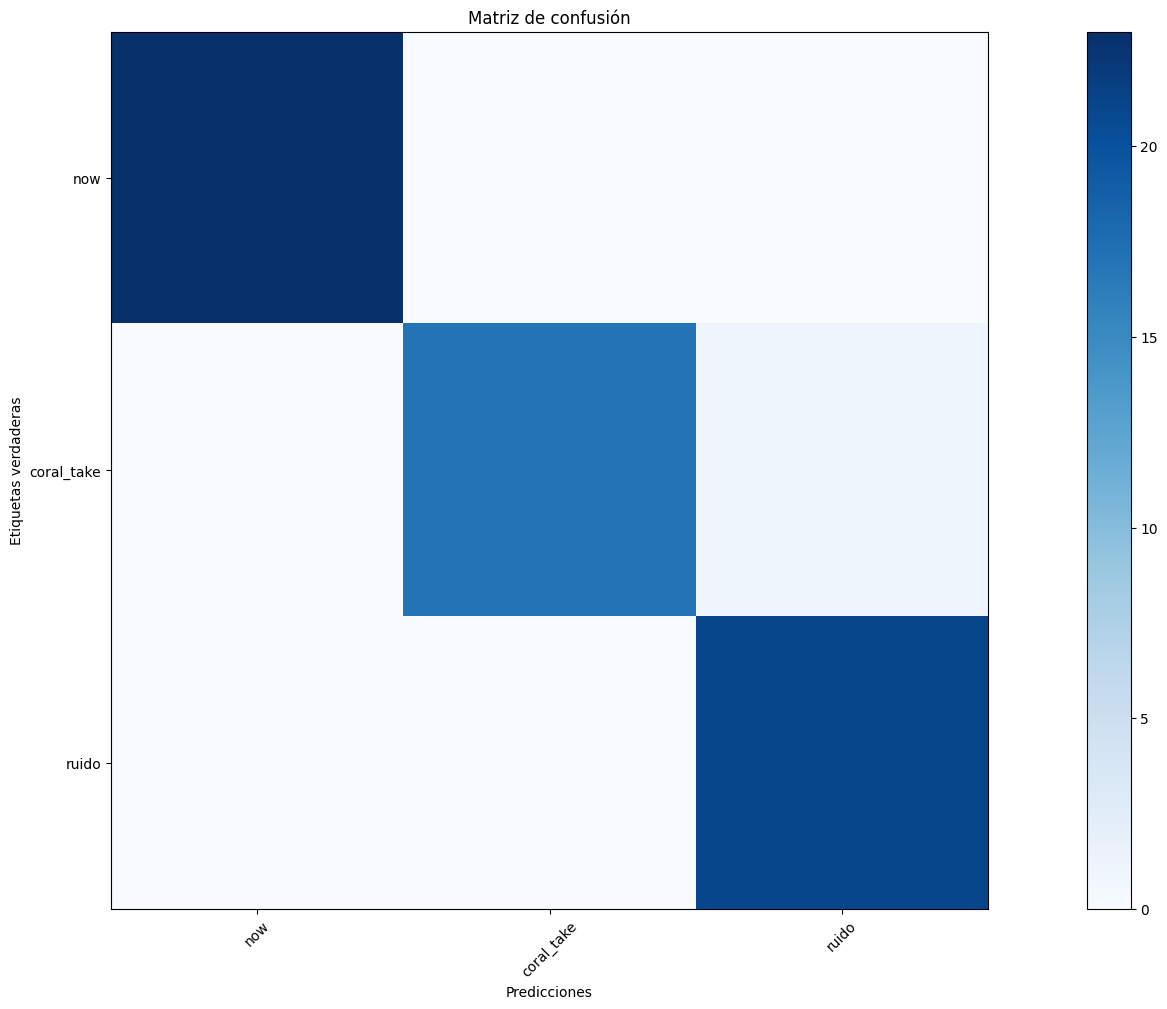

In [11]:
# use the model to predict the test inputs
# inputs_test = np.expand_dims(inputs_test, axis=1)
predictions = model.predict(inputs_test)

import numpy as np
import matplotlib.pyplot as plt

# Calcula la matriz de confusión utilizando NumPy
num_classes = len((outputs_test[1]))
print('class:',num_classes)
confusion_matrix = np.zeros((num_classes, num_classes))

for i in range(len(outputs_test)):
    true_class = np.argmax(outputs_test[i])
    predicted_class = np.argmax(predictions[i])
    # print(predicted_class)
    # print(true_class)
    confusion_matrix[true_class][predicted_class] += 1

print(confusion_matrix)

# Imprime la matriz de confusión utilizando la biblioteca matplotlib.pyplot
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
plt.title("Matriz de confusión")
plt.colorbar()
tick_marks = np.arange(len(commands))
plt.xticks(tick_marks, commands, rotation=45)
plt.yticks(tick_marks, commands)
plt.tight_layout()
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.show()



# for i in range(len(predictions)):
#     # print the predictions and the expected ouputs
#     print("predictions =\n", np.round(predictions[i]))
#     print("actual =\n", outputs_test[i])


Convert model to tensorflow lite

In [12]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("command_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("command_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: C:\Users\enric\AppData\Local\Temp\tmpzzzt902w\assets


INFO:tensorflow:Assets written to: C:\Users\enric\AppData\Local\Temp\tmpzzzt902w\assets


Model is 341360 bytes


In [13]:
# tf.saved_model.save(model, "register\my_saved_model")

In [14]:
# Convertir el modelo a formato TensorFlow Lite sin cuantización
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Convertir el modelo TensorFlow Lite a una representación en memoria como bytes
tflite_model_content = bytes(tflite_model)

# Escribir el modelo como un archivo de texto en formato C en memoria
model_h_content = """
const unsigned char model[] = {
  %s
};
""" % ", ".join([str(b) for b in tflite_model_content])

# Escribir el archivo .h en el disco
with open('modelo.h', 'w') as f:
    f.write(model_h_content)
    
print(f"Header file, modelo.h, is {len(model_h_content):,} bytes.")
print("El archivo modelo.h ha sido guardado.")

INFO:tensorflow:Assets written to: C:\Users\enric\AppData\Local\Temp\tmpkz6i8owf\assets


INFO:tensorflow:Assets written to: C:\Users\enric\AppData\Local\Temp\tmpkz6i8owf\assets


Header file, modelo.h, is 1,540,279 bytes.
El archivo modelo.h ha sido guardado.
